Starting experiment with 10 vehicles, learning rate 0.003, entropy coefficient 0.01, and discount factor 0.4
Starting experiment with 10 vehicles, learning rate 0.003, entropy coefficient 0.01, and discount factor 0.9
Starting experiment with 10 vehicles, learning rate 0.003, entropy coefficient 0.08, and discount factor 0.4
Starting experiment with 10 vehicles, learning rate 0.003, entropy coefficient 0.08, and discount factor 0.9
Starting experiment with 10 vehicles, learning rate 0.0003, entropy coefficient 0.01, and discount factor 0.4
Starting experiment with 10 vehicles, learning rate 0.0003, entropy coefficient 0.01, and discount factor 0.9
Starting experiment with 10 vehicles, learning rate 0.0003, entropy coefficient 0.08, and discount factor 0.4
Starting experiment with 10 vehicles, learning rate 0.0003, entropy coefficient 0.08, and discount factor 0.9
Starting experiment with 50 vehicles, learning rate 0.003, entropy coefficient 0.01, and discount factor 0.4
Starting experi

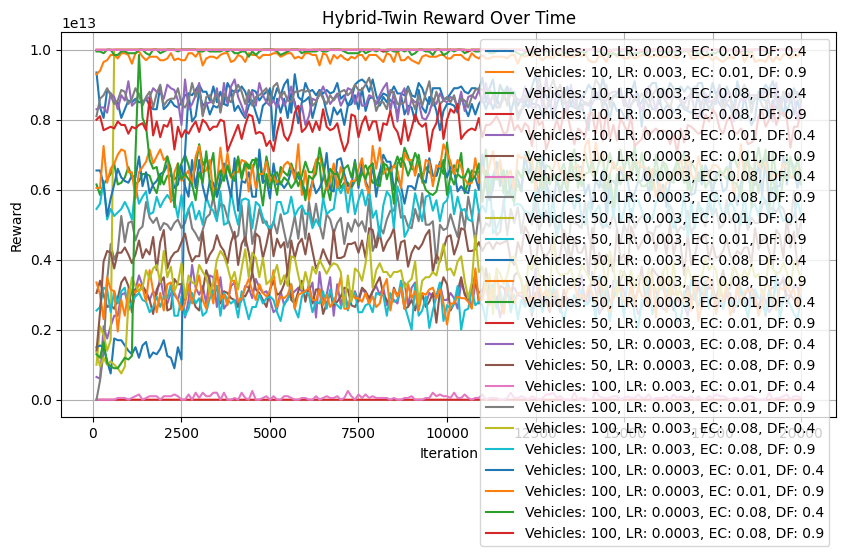

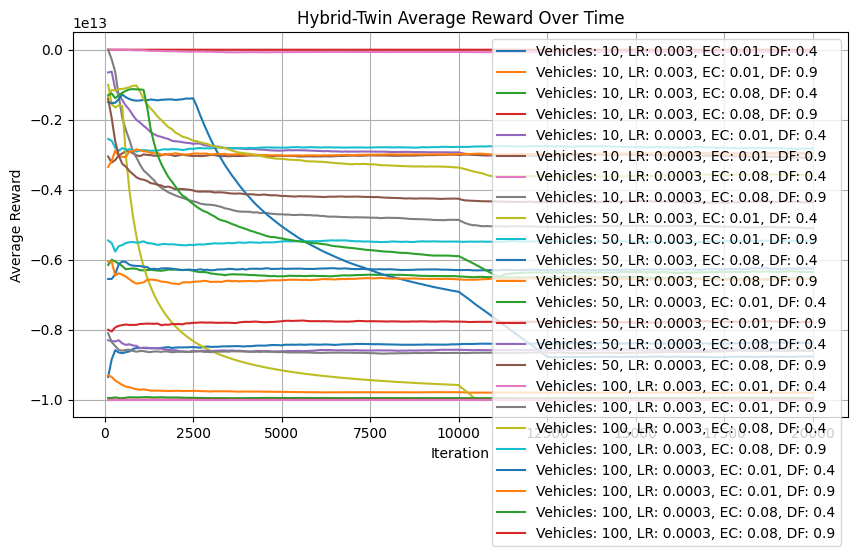

In [27]:
import numpy as np
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical, Normal
import matplotlib.pyplot as plt
import random
import pandas as pd
import os

SEED = 50
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


# Define the environment
class TaskOffloadingEnv(gym.Env):
    def __init__(self, n_vehicles, F_RSU=10e9, F_C=20e9, max_steps=100):
        super(TaskOffloadingEnv, self).__init__()
        self.n = n_vehicles
        self.F_RSU = F_RSU
        self.F_C = F_C
        self.max_steps = max_steps
        self.current_step = 0

        self.action_space = spaces.Tuple((
            spaces.MultiBinary(self.n),
            spaces.Box(low=1e9, high=2e9, shape=(self.n,), dtype=np.float32),
            spaces.Box(low=2e9, high=4e9, shape=(self.n,), dtype=np.float32)
        ))

        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(12 * self.n,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.d_V = np.random.randint(31000, 31010, self.n) * 8
        self.c_V = np.random.randint(5, 6, self.n) * 1e3 / 8
        self.tau_V = np.random.randint(5, 6, self.n)
        self.bar_d_V = np.random.randint(15500, 15510, self.n) * 8
        self.f_V = np.random.randint(1, 2, self.n) * 1e9
        self.T_upload_RSU = np.random.randint(20, 21, self.n) * 1e6
        self.T_download_RSU = np.random.randint(40, 41, self.n) * 1e6
        self.T_upload_C = np.random.randint(20, 21, self.n) * 1e7
        self.T_download_C = np.random.randint(40, 41, self.n) * 1e7
        self.T_b = np.random.randint(100, 101, self.n) * 1e6
        self.v_V = np.random.randint(20, 21, self.n)
        self.R = np.random.randint(1000, 1001, self.n)

        return np.concatenate([self.d_V, self.c_V, self.tau_V, self.bar_d_V, self.f_V, 
                               self.T_upload_RSU, self.T_download_RSU, self.T_upload_C, 
                               self.T_download_C, self.T_b, self.v_V, self.R])

    def step(self, action):
        self.current_step += 1

        x_V, F_RSU_V, F_C_V = action 
        x_V = x_V.reshape(-1)  # Flatten the action array if necessary
        F_RSU_V = F_RSU_V.flatten()
        F_C_V = F_C_V.flatten()

        T_total = 0
        tau_total_edge=0
        tau_total=0
        T_V_edge=0
        for i in range(self.n):
            #tau_total_edge+=(1-z_V[i])*self.tau_V[i]
            tau_total+=self.tau_V[i]
            counter=0
            T_V_j = (self.d_V[i] / self.T_upload_RSU[i]) + ((self.d_V[i] * self.c_V[i]) / (F_RSU_V[i])) + (self.bar_d_V[i] / self.T_download_RSU[i])+2*0.003*1e-3 #latency for reaching edge
            if x_V[i] == 0: #uuse local
                T_V_i = (self.d_V[i] * self.c_V[i]) / self.f_V[i]
            else:
                    if (self.v_V[i]*T_V_j) <= self.R[i]: #y_V[i]=0 within range use edge
                        counter+=counter
                        T_V_i=T_V_j
                    else: #beyond range use cloud
                       T_V_i=(self.d_V[i] / self.T_upload_C[i]) + ((self.d_V[i] * self.c_V[i]) / (F_C_V[i])) + (self.bar_d_V[i] / self.T_download_C[i])+2*0.3*1e-3 #latency for reaching cloud
                    
            T_total += T_V_i

        # Ensure x_V and F_RSU_V are tensors before applying operations
        x_V = torch.as_tensor(x_V, dtype=torch.float32)
        F_RSU_V = torch.as_tensor(F_RSU_V, dtype=torch.float32)
        F_C_V = torch.as_tensor(F_C_V, dtype=torch.float32)

        # Use PyTorch's sum for tensor operations
        if  torch.sum(x_V *counter*F_RSU_V)>self.F_RSU or torch.sum(x_V *(self.n-counter)*F_C_V)>self.F_C or (T_total>tau_total):
            reward = -1e11
        else:
        #original way
            reward = -T_total
        
        #one way
        #   alpha = 1e6  # Scaling factor to adjust the magnitude of the reward
        #   T_total = max(T_total, 1e-6)  # Prevent division by zero
        #   reward = alpha / T_total  # Higher reward for lower latency

        #another way
        #    max_latency=1000
        #    desired_reward_for_max_latency=0.1
        #    scaling_factor=-max_latency / 0.1   
        #    reward = np.exp(-T_total / scaling_factor)

        next_state = np.concatenate([self.d_V, self.c_V, self.tau_V, self.bar_d_V, self.f_V, self.T_upload_RSU, self.T_download_RSU, self.T_upload_C, self.T_download_C, self.T_b, self.v_V, self.R])

        # Check if the episode should terminate
        done = self.current_step >= self.max_steps

        return next_state, reward, done, {}

# Define the Actor-Critic model ........now this 
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, std=0.2):
        super(ActorCritic, self).__init__()
        self.common = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )

        self.actor_fc = nn.Linear(hidden_size, num_actions)  # Discrete x action probabilities
        #self.actor_fc2 = nn.Linear(hidden_size, num_actions)  # discrete z action probabilities
        self.actor_fc3 = nn.Linear(hidden_size, num_actions)  # Continuous action means2
        self.actor_fc4 = nn.Linear(hidden_size, num_actions)  # Continuous action means3

        self.critic = nn.Linear(hidden_size, 1)

        self.log_std = nn.Parameter(torch.ones(1, num_actions) * std)
        

    def forward(self, x):
        x = self.common(x)

        probs = torch.sigmoid(self.actor_fc(x))  # Discrete action probabilities sigmoid gives 0 1 

        #probsz = torch.sigmoid(self.actor_fc2(x))  # Discrete action probabilities sigmoid gives 0 1 
        
        means2 = self.actor_fc3(x)  # Continuous action2 means
        stds2 = self.log_std.expand_as(means2)   ####################################################################################exponential
        
        means3 = self.actor_fc4(x)  # Continuous action3 means
        stds3 = self.log_std.expand_as(means3)   ####################################################################################exponential
        
        value = self.critic(x)

        return probs, means2, stds2, means3, stds3, value

# Helper functions for PPO

def compute_returns(next_value, rewards, masks, gamma): #no change gamma discount factor determines the importance of future rewards. A value close to 1 will make the agent consider future rewards more strongly, potentially leading to better long-term decisions. 
    R1 = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R1 = rewards[step] + gamma * R1 * masks[step]
        returns.insert(0, R1)
    return returns

def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage): #no change
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]

# Helper functions for PPO
def ppo_update(model, optimizer, ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, entropy_coefficient, clip_param=0.2): #clip_parameter is the epsilon of the equation
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist_probs, means2, stds2, means3, stds3, value = model(state) #dist_probs=probs=discrete action
            
            #continuous
            action_continuous2 = action[:, n_vehicles:2*n_vehicles] #.........
            action_continuous3 = action[:, 2*n_vehicles:] #.........
            dist_normal2 = Normal(means2, stds2)
            dist_normal3 = Normal(means3, stds3)
            new_log_prob_continuous2 = dist_normal2.log_prob(action_continuous2).sum(1, keepdim=True)
            new_log_prob_continuous3 = dist_normal3.log_prob(action_continuous3).sum(1, keepdim=True)
            

            # Assuming action is concatenated: first part is discrete, second part is continuous shapes of actions have no problem i checked
            action_discrete = action[:, :n_vehicles]  #index ......................
            #action_discretez = action[:, n_vehicles:2*n_vehicles]
            ##print("ppo_update action_discrete", action_discrete)
            ##print("ppo_update action_discrete_shape", action_discrete.shape)
            # Create the distributions
            dist_categorical = Categorical(logits=dist_probs)
            #dist_categoricalz = Categorical(logits=dist_probsz)

            action_discrete_i_list=[]
            new_log_prob_discrete_list = []
            #action_discrete_i_listz=[]
            #new_log_prob_discrete_listz = []
            for i in range(n_vehicles):
                action_discrete_i = action_discrete[:, i]  # Select actions for vehicle i
                action_discrete_i_list.append(action_discrete_i.unsqueeze(-1))
                new_log_prob_discrete_i = dist_categorical.log_prob(action_discrete_i)
                new_log_prob_discrete_list.append(new_log_prob_discrete_i.unsqueeze(-1))  # Unsqueeze to prepare for stacking
                
                #action_discrete_iz = action_discretez[:, i]  # Select actions for vehicle i
                #action_discrete_i_listz.append(action_discrete_iz.unsqueeze(-1))
                #new_log_prob_discrete_iz = dist_categoricalz.log_prob(action_discrete_iz)
                #new_log_prob_discrete_listz.append(new_log_prob_discrete_iz.unsqueeze(-1))  # Unsqueeze to prepare for stacking
            
            # Stack along the last dimension to get the shape
            
            new_action_discrete_i = torch.cat(action_discrete_i_list, dim=-1)
            new_log_prob_discrete_i = torch.cat(new_log_prob_discrete_list, dim=-1)
            
            #new_action_discrete_iz = torch.cat(action_discrete_i_listz, dim=-1)
            #new_log_prob_discrete_iz = torch.cat(new_log_prob_discrete_listz, dim=-1)
            
            #merge
            new_log_probs = new_log_prob_discrete_i + new_log_prob_continuous2 + new_log_prob_continuous3

            
            ratio = (new_log_probs / (old_log_probs))#.exp() #this ratio must be divided not subtract ####################################################################################exponential
            surr1 = ratio * advantage #i know what is this from youtube advantage is the gain
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage #The clip parameter in PPO controls the degree to which the policy can be updated. Adjusting this value can help in stabilizing training by preventing large policy updates.

            actor_loss = -torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            optimizer.zero_grad()
            entropy = dist_categorical.entropy().mean() +dist_normal2.entropy().mean()+dist_normal3.entropy().mean() 
            #entropy_coefficient=0.08#grows to 0.1 Adjust the entropy coefficient to balance exploration and exploitation. Increasing entropy can encourage the agent to explore more, which can be beneficial in complex environments with many local optima.
            total_loss = actor_loss + 0.5 * critic_loss - entropy_coefficient * entropy
            total_loss.backward()

            ##these two lines treat the NaN values that are witnessed at some point in the iteration running
            # Gradient Clipping
            max_norm = 0.5  # You can adjust this value as needed
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            optimizer.step()


# Hepler Functions for PPO 
def evaluate_policy(env, model, n_vehicles,episodes=2):
    total_reward = 0.0
    for _ in range(episodes):
        state = env.reset()
        done = False
        while not done:
            state = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                dist_probs, means2, stds2, means3, stds3, _ = model(state)
                if torch.isnan(dist_probs).any() or torch.isnan(means2).any() or torch.isnan(stds2).any() or torch.isnan(means3).any() or torch.isnan(stds3).any() :
                    print("NaN detected in output of model")
                    # Handle the NaN case, e.g., by skipping the iteration, logging more info, or raising an error
                    continue  # or raise an exception
                action_cat = Categorical(dist_probs)
                action_discrete = action_cat.sample(sample_shape=torch.Size([n_vehicles]))
                action_discrete = action_discrete.reshape(1, n_vehicles)
                #action_catz = Categorical(dist_probsz)
                #action_discretez = action_catz.sample(sample_shape=torch.Size([n_vehicles]))
                #action_discretez = action_discretez.reshape(1, n_vehicles)
                
                action_continuous2 = Normal(means2, stds2).sample()
                action_continuous3 = Normal(means3, stds3).sample()
                

                action = (action_discrete, action_continuous2.numpy(), action_continuous3.numpy())
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            state = next_state

    average_reward = total_reward / episodes
    return average_reward

# Function to run the experiment
def run_experiment(n_vehicles, learning_rate,entropy_coefficient,gamma):
    env = TaskOffloadingEnv(n_vehicles=n_vehicles)
    num_inputs = env.observation_space.shape[0]
    num_actions = n_vehicles
    minimum_batch_size=64

    model = ActorCritic(num_inputs, num_actions, hidden_size=512)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    max_frames = 20000
    frame_idx = 0
    test_rewards = []
    test_rewards2 = []
    epochs_recorded = []
    epochs_recorded2 = []
    test_loss = []
    losses=[]

    state = env.reset()
    best_reward = float('-inf')  ####### new Initialize best reward seen so far

    while frame_idx < max_frames:
        log_probs = []
        values = []
        states = []
        actions = []
        rewards = []
        masks = []
    
        for _ in range(100):
            state = torch.FloatTensor(state).unsqueeze(0)
            dist_probs, means2, stds2, means3, stds3, value = model(state) #...........................................
            
            # discrete actions x_V
            dist_probs = dist_probs.squeeze(0)
            action_cat = Categorical(logits=dist_probs)
            action_discrete = action_cat.sample(sample_shape=torch.Size([n_vehicles]))
            action_discrete=action_discrete.reshape(1, n_vehicles)
            #dist_probsz = dist_probsz.squeeze(0)
            #action_catz = Categorical(logits=dist_probsz)
            #action_discretez = action_catz.sample(sample_shape=torch.Size([n_vehicles]))
            #action_discretez=action_discretez.reshape(1, n_vehicles)
    
            # continuous actions z_V, F_RSU_V, F_C_V
            action_continuous2 = Normal(means2, stds2).sample() #........................................... F_RSU_V
            #action_continuous2 = torch.clamp(action_continuous2, min=0.5e9, max=2e9)
            action_continuous2_np = action_continuous2.numpy() 
            
            action_continuous3 = Normal(means3, stds3).sample() #........................................... F_C_V
            #action_continuous3 = torch.clamp(action_continuous3, min=2e9, max=4e9)
            action_continuous3_np = action_continuous3.numpy() 
            
            action = (action_discrete, action_continuous2_np,action_continuous3_np)
            
            next_state, reward, done, _ = env.step(action)
            log_prob = action_cat.log_prob(action_discrete) + Normal(means2, stds2).log_prob(action_continuous2).sum(1, keepdim=True) + Normal(means3, stds3).log_prob(action_continuous3).sum(1, keepdim=True) #..........................................
            
            states.append(state)
            actions.append(torch.cat([action_discrete, action_continuous2, action_continuous3], 1)) #............................................
            rewards.append(reward)
            masks.append(1 - done)
            values.append(value)
            log_probs.append(log_prob)
    
            state = next_state
            frame_idx += 1
    
            if done:
                state = env.reset()
    
        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        with torch.no_grad():
            _, _, _, _, _, next_value = model(next_state)
            
        returns = compute_returns(next_value, rewards, masks,gamma) #found values
    
        returns = torch.cat(returns).detach()
        log_probs = torch.cat(log_probs).detach()
        values = torch.cat(values).detach() #actual values
        states = torch.cat(states)
        actions = torch.cat(actions)
        advantage = returns - values #it is the gain or the advantage obtained from the value network
        ppo_epoch=4
        ppo_update(model, optimizer, ppo_epoch, minimum_batch_size, states, actions, log_probs, returns, advantage, entropy_coefficient)
    
        if frame_idx % 100 == 0:
            test_reward = evaluate_policy(env, model,n_vehicles)
            test_rewards.append(-1*test_reward)
            epochs_recorded.append(frame_idx)
            #print('Epoch %s. Latency: %s' % (frame_idx, test_reward))
            avg_reward = np.mean(test_rewards[-100:])  # Average reward over last 10 episodes
            avg_loss = np.mean(losses[-100:]) if losses else 0  # Average loss over last 10 iterations

            # Check for convergence based on your criteria
            if avg_reward >= best_reward:  # Example convergence criteria (can be customized)
                best_reward = avg_reward
                #torch.save(model.state_dict(), f'best_model_{n_vehicles}_{learning_rate}.pt')

            # Record metrics for plotting
            test_rewards2.append(-1*avg_reward)
            epochs_recorded2.append(frame_idx)

    # After running the experiment, save the results to a DataFrame
    data1 = pd.DataFrame({
        'Iteration': epochs_recorded,                                            #here here here here here
        'Avg Reward': test_rewards,                                              #here here here here here
        'Vehicles': n_vehicles,
        'Learning Rate': learning_rate,
        'Entropy Coefficient': entropy_coefficient,
        'Discount Factor': gamma
        })
    data2 = pd.DataFrame({
        'Iteration': epochs_recorded2,                                            #here here here here here
        'Avg Reward': test_rewards2,                                              #here here here here here
        'Vehicles': n_vehicles,
        'Learning Rate': learning_rate,
        'Entropy Coefficient': entropy_coefficient,
        'Discount Factor': gamma
       })
    # Append the DataFrame to the list
    all_results1.append(data1)
    all_results2.append(data2)
    
# Initialize an empty list to store experiment results
all_results1 = []
all_results2 = []
n_vehicles_options = [10,50,100]
learning_rate_options = [3e-3,3e-4]
entropy_coefficient_options = [0.01,0.08]
gamma_options = [0.4,0.9]


for n_vehicles in n_vehicles_options:
    for learning_rate in learning_rate_options:
        for entropy_coefficient in entropy_coefficient_options:
            for gamma in gamma_options:
                print(f'Starting experiment with {n_vehicles} vehicles, learning rate {learning_rate}, '
                      f'entropy coefficient {entropy_coefficient}, and discount factor {gamma}')
                run_experiment(n_vehicles, learning_rate, entropy_coefficient, gamma)

# Concatenate all DataFrames in the list into a single DataFrame
combined_results1 = pd.concat(all_results1)
combined_results2 = pd.concat(all_results2)

# Save the combined DataFrame to a CSV file
file_path1 = 'combined_results1_hybrid_twin_newfile_+ve+all_rewards.csv'
combined_results1.to_csv(file_path1, index=False)
file_path2 = 'combined_results2_hybrid_twin_newfile_+ve+all_rewards.csv'
combined_results2.to_csv(file_path2, index=False)

# Plotting and saving the results (optional)
plt.figure(figsize=(10, 5))
for n_vehicles in n_vehicles_options:
    for learning_rate in learning_rate_options:
        for entropy_coefficient in entropy_coefficient_options:  # Add different entropy coefficients
            for discount_factor in gamma_options:  # Add different discount factors
                data_subset = combined_results1[(combined_results1['Vehicles'] == n_vehicles) & 
                                               (combined_results1['Learning Rate'] == learning_rate) &
                                               (combined_results1['Entropy Coefficient'] == entropy_coefficient) &
                                               (combined_results1['Discount Factor'] == discount_factor)]
                plt.plot(data_subset['Iteration'], data_subset['Avg Reward'], label=f'Vehicles: {n_vehicles}, LR: {learning_rate}, EC: {entropy_coefficient}, DF: {discount_factor}')

plt.title("Hybrid-Twin Reward Over Time")
plt.xlabel("Iteration")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
for n_vehicles in n_vehicles_options:
    for learning_rate in learning_rate_options:
        for entropy_coefficient in entropy_coefficient_options:  # Add different entropy coefficients
            for discount_factor in gamma_options:  # Add different discount factors
                data_subset = combined_results2[(combined_results2['Vehicles'] == n_vehicles) & 
                                               (combined_results2['Learning Rate'] == learning_rate) &
                                               (combined_results2['Entropy Coefficient'] == entropy_coefficient) &
                                               (combined_results2['Discount Factor'] == discount_factor)]
                plt.plot(data_subset['Iteration'], data_subset['Avg Reward'], label=f'Vehicles: {n_vehicles}, LR: {learning_rate}, EC: {entropy_coefficient}, DF: {discount_factor}')

plt.title("Hybrid-Twin Average Reward Over Time")
plt.xlabel("Iteration")
plt.ylabel("Average Reward")
plt.legend()
plt.grid(True)
plt.show()